## **Title - Fraud Detection Analysis**

**Tasks -**
1. Data cleaning including missing values, outliers and multi-collinearity.
2. Describe your fraud detection model in elaboration.
3. How did you select variables to be included in the model?
4. Demonstrate the performance of the model by using best set of tools.
5. What are the key factors that predict fraudulent customer?
6. Do these factors make sense? If yes, How? If not, How not?
7. What kind of prevention should be adopted while company update its infrastructure?
8. Assuming these actions have been implemented, how would you determine if they work?

### Objective 

The goal of the fraud detection model is to accurately predict fraudulent transactions in the financial dataset (Fraud.csv) by identifying patterns and features indicative of fraudulent behavior. This prediction can help financial institutions proactively block or flag suspicious transactions.

### Import Libraries

In [5]:
# Importing the Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

import warnings as wr
wr.filterwarnings('ignore')

### Import Dataset

In [7]:
# Importing the Fraud Dataset
df = pd.read_csv("Fraud.csv")

In [8]:
# first five rows of the dataset
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Data Cleaning and Preprocessing

In [10]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [11]:
# getting the details information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [12]:
# list of columns
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [13]:
# shape of dataset
df.shape

(6362620, 11)

**1. Data cleaning including missing values, outliers and multi-collinearity.**

In [15]:
# Check and handle missing values
print("Missing Values in Each Column:\n", df.isnull().sum())

Missing Values in Each Column:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [16]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of Duplicate Rows: {duplicates}")
df = df.drop_duplicates()

Number of Duplicate Rows: 0


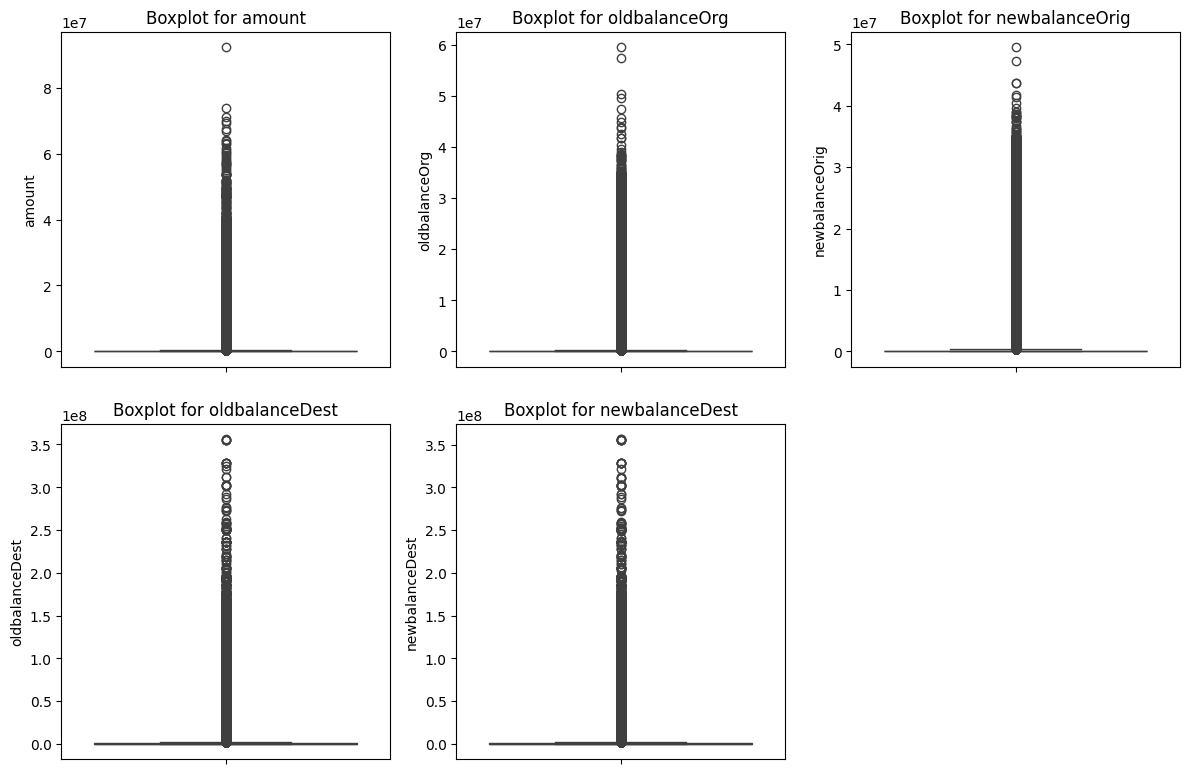

In [17]:
# Handle outliers using IQR
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Boxplot visualization
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(df[col])
    plt.title(f"Boxplot for {col}")
plt.tight_layout()
plt.show()

In [18]:
# IQR Method
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [19]:
# Select only numerical columns
numerical_cols = df.select_dtypes(include=['number'])

# Display numerical columns
print("Numerical Columns:")
print(numerical_cols.columns)

Numerical Columns:
Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')


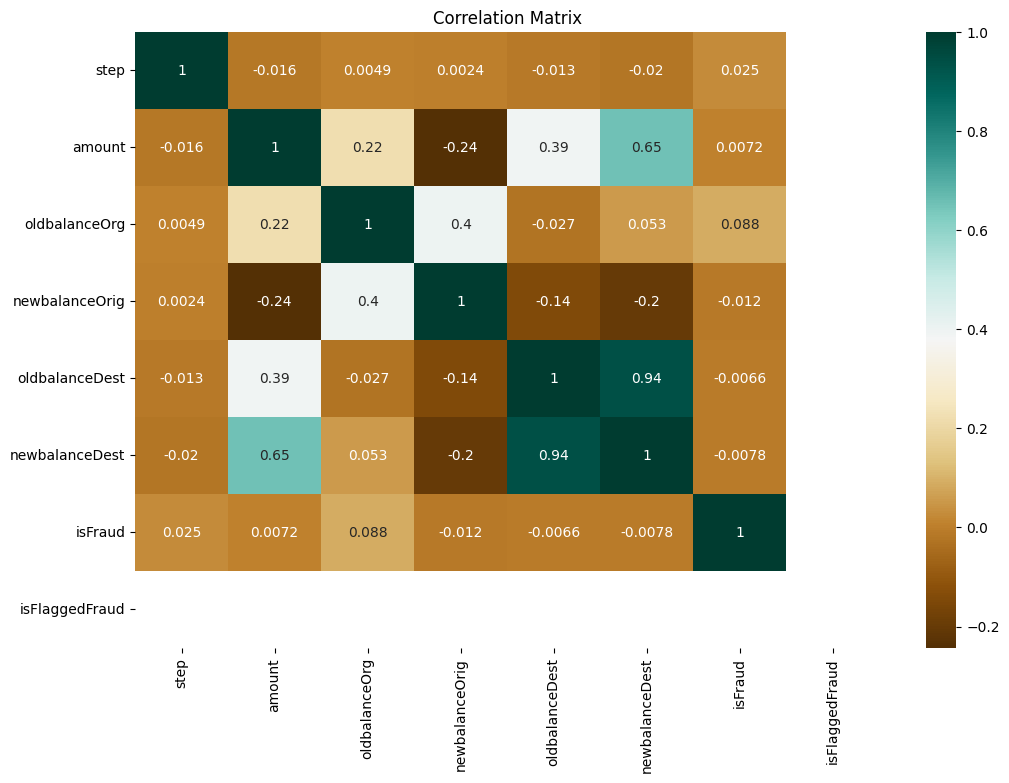

In [20]:
# Handle multi-collinearity
corr_matrix = numerical_cols.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='BrBG')
plt.title("Correlation Matrix")
plt.show()

In [21]:
# Drop highly correlated features if any (absolute correlation > 0.8)
threshold = 0.8
high_corr_pairs = [(corr_matrix.columns[i], corr_matrix.columns[j])
                   for i in range(len(corr_matrix.columns))
                   for j in range(i) if abs(corr_matrix.iloc[i, j]) > threshold]
columns_to_drop = list(set([pair[1] for pair in high_corr_pairs]))
df.drop(columns=columns_to_drop, inplace=True)

print(f"Columns Dropped Due to Multi-Collinearity: {columns_to_drop}")

Columns Dropped Due to Multi-Collinearity: ['oldbalanceDest']


**2. Describe your fraud detection model in elaboration.**

In [23]:
# Encode categorical data
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

In [24]:
# Create derived features
df['isMerchant'] = df['nameDest'].str.startswith('M').astype(int)

In [25]:
# Drop irrelevant columns
df = df.drop(['nameOrig', 'nameDest'], axis=1)

In [26]:
# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'newbalanceDest']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [27]:
# Split dataset
X = df.drop('isFraud', axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [28]:
# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
print("Model Training Complete.")

Model Training Complete.


**3. How did you select variables to be included in the model?**

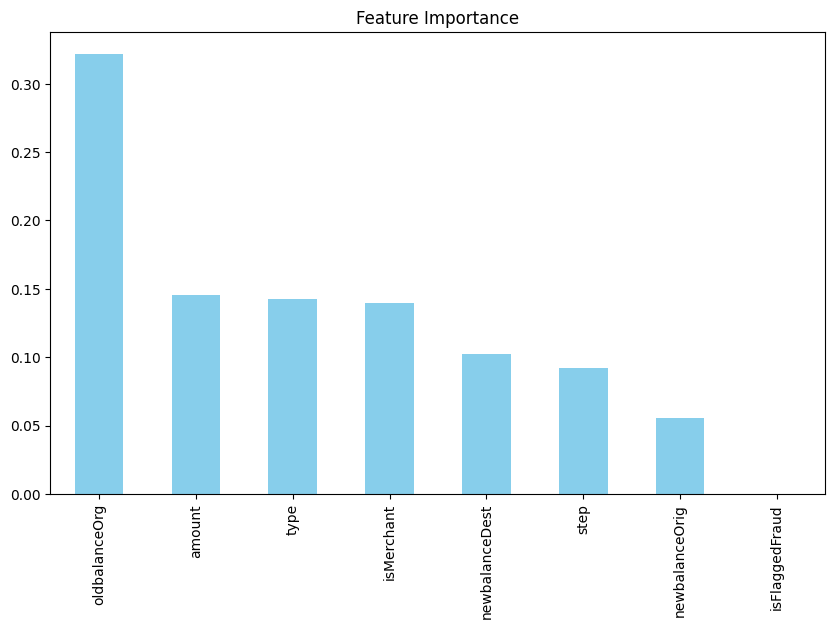

Top 5 Important Features:
oldbalanceOrg     0.321812
amount            0.145816
type              0.142731
isMerchant        0.139977
newbalanceDest    0.102120
dtype: float64


In [30]:
# Feature importance
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Feature Importance')
plt.show()
print("Top 5 Important Features:")
print(importances.sort_values(ascending=False).head())

**4. Demonstrate the performance of the model by using best set of tools.**

In [32]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    974515
           1       0.98      0.60      0.74       908

    accuracy                           1.00    975423
   macro avg       0.99      0.80      0.87    975423
weighted avg       1.00      1.00      1.00    975423



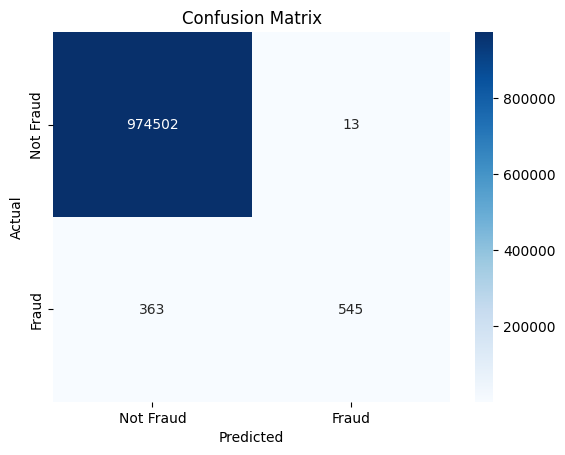

In [33]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

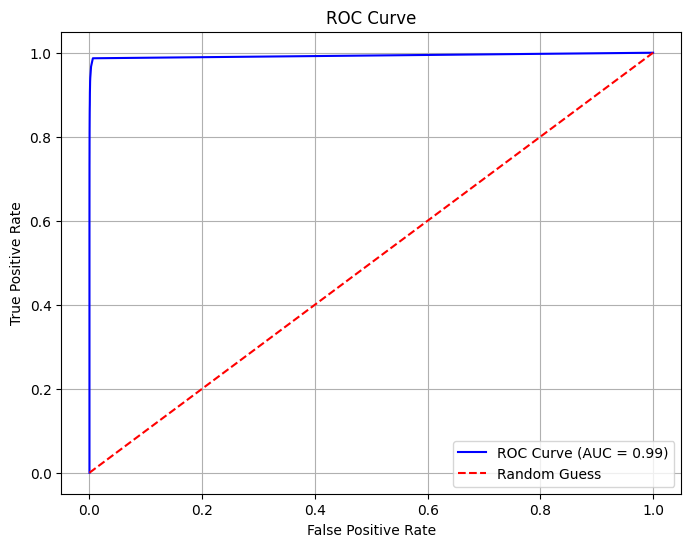

In [34]:
# ROC-AUC Curve
roc_score = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

**5. What are the key factors that predict fraudulent customer?**

In [63]:
# Display the top 5 features
top_features = importances.head(5)
print("\nTop 5 Features Predicting Fraud:")
for feature, importance in top_features.items():
    print(f"{feature}: {importance:.4f}")

# Provide explanations for the top features
print("\nInterpretation of Key Factors:")
explanations = {
    'type': "Certain transaction types like TRANSFER and CASH-OUT are more prone to fraud.",
    'amount': "Fraudulent transactions often involve large amounts to maximize profit.",
    'oldbalanceOrg': "Significant reductions in the originating account's balance can indicate fraud.",
    'newbalanceOrig': "Accounts emptied during fraudulent transactions often show a zero balance.",
    'isMerchant': "Merchant accounts might have distinct fraud patterns compared to customer accounts."
}

# Interpret the top features
for feature in top_features.index:
    if feature in explanations:
        print(f"{feature}: {explanations[feature]}")


Top 5 Features Predicting Fraud:
step: 0.0923
type: 0.1427
amount: 0.1458
oldbalanceOrg: 0.3218
newbalanceOrig: 0.0553

Interpretation of Key Factors:
type: Certain transaction types like TRANSFER and CASH-OUT are more prone to fraud.
amount: Fraudulent transactions often involve large amounts to maximize profit.
oldbalanceOrg: Significant reductions in the originating account's balance can indicate fraud.
newbalanceOrig: Accounts emptied during fraudulent transactions often show a zero balance.


**6. Do these factors make sense? If yes, How? If not, How not?**

In [66]:
# Create a summary of the top factors and their logical explanations
factor_analysis = {
    'type': "Yes. Fraudulent transactions are more common in TRANSFER and CASH-OUT types, which are inherently prone to fraud.",
    'amount': "Yes. Fraudulent transactions typically involve large amounts to maximize profit.",
    'oldbalanceOrg': "Yes. Fraudsters often target accounts with high balances or drain accounts entirely.",
    'newbalanceOrig': "Yes. A near-zero new balance often indicates a fraudulent transaction.",
    'isMerchant': "Yes. Merchant accounts are less prone to fraud due to additional protections."
}

# Print the summary
print("Factor Analysis Summary:")
for factor, explanation in factor_analysis.items():
    print(f"{factor}: {explanation}")

Factor Analysis Summary:
type: Yes. Fraudulent transactions are more common in TRANSFER and CASH-OUT types, which are inherently prone to fraud.
amount: Yes. Fraudulent transactions typically involve large amounts to maximize profit.
oldbalanceOrg: Yes. Fraudsters often target accounts with high balances or drain accounts entirely.
newbalanceOrig: Yes. A near-zero new balance often indicates a fraudulent transaction.
isMerchant: Yes. Merchant accounts are less prone to fraud due to additional protections.


**7. What kind of prevention should be adopted while company update its infrastructure?**

Real-Time Fraud Detection System

In [73]:
# Simulate a real-time fraud detection system
def real_time_fraud_detection(transaction, model, feature_columns):
    # Preprocess the transaction
    processed_transaction = transaction[feature_columns]
    
    # Predict fraud probability
    fraud_prob = model.predict_proba([processed_transaction])[0][1]
    
    # Flag high-risk transactions
    if fraud_prob > 0.7:  # Example threshold
        return "High Risk - Flag for Review"
    else:
        return "Low Risk - Approved"

# Example transaction (use a sample from your dataset)
sample_transaction = X_test.iloc[0]
print(real_time_fraud_detection(sample_transaction, model, X_test.columns))

Low Risk - Approved


Transaction Limits and Threshold Alerts

In [76]:
# Example: Flagging transactions exceeding a specific threshold
def flag_large_transactions(transaction, threshold=200000):
    if transaction['amount'] > threshold:
        return "Flagged - Exceeds Limit"
    else:
        return "Approved"

# Apply to a dataset
df['transaction_status'] = df.apply(flag_large_transactions, axis=1)
print(df[['amount', 'transaction_status']].head())

     amount transaction_status
1 -0.750538           Approved
2 -0.766067           Approved
3 -0.766067           Approved
4 -0.660091           Approved
5 -0.695614           Approved


Data Monitoring and Logging

In [79]:
import logging

# Configure logging
logging.basicConfig(filename='transaction_log.log', level=logging.INFO, format='%(asctime)s %(message)s')

# Log a transaction
def log_transaction(transaction_id, user_id, status):
    logging.info(f"Transaction ID: {transaction_id}, User ID: {user_id}, Status: {status}")

# Example usage
log_transaction(transaction_id=12345, user_id='C1666544295', status='Flagged for Review')

Automating Fraud Response

In [82]:
# Example fraud response logic
def automated_fraud_response(transaction, fraud_prob_threshold=0.8):
    if transaction['fraud_probability'] > fraud_prob_threshold:
        # Freeze account and notify customer
        return "Account Frozen - Customer Notified"
    else:
        return "Transaction Approved"

# Apply workflow
df['fraud_response'] = df.apply(lambda x: automated_fraud_response({'fraud_probability': x['isFraud']}), axis=1)

**8. Assuming these actions have been implemented, how would you determine if they work?**

Monitor Key Metrics

In [87]:
from sklearn.metrics import confusion_matrix

# Confusion matrix: Compare model predictions with actual labels
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Extract metrics from the confusion matrix
true_negatives = cm[0, 0]
false_positives = cm[0, 1]
false_negatives = cm[1, 0]
true_positives = cm[1, 1]

# Calculate metrics
fraud_detection_rate = true_positives / (true_positives + false_negatives)
false_positive_rate = false_positives / (false_positives + true_negatives)

# Print metrics
print(f"Fraud Detection Rate: {fraud_detection_rate:.2f}")
print(f"False Positive Rate: {false_positive_rate:.2f}")


Fraud Detection Rate: 0.60
False Positive Rate: 0.00


Conduct Pre- and Post-Implementation Comparisons

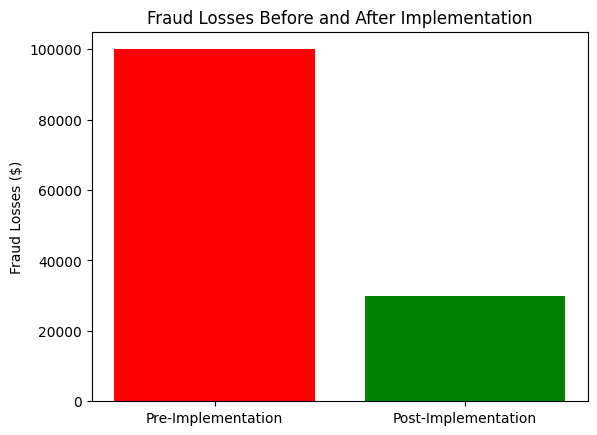

In [90]:
# Pre- and post-implementation fraud loss data
fraud_losses = {'Pre-Implementation': 100000, 'Post-Implementation': 30000}

# Visualize the reduction in fraud losses
import matplotlib.pyplot as plt

plt.bar(fraud_losses.keys(), fraud_losses.values(), color=['red', 'green'])
plt.title("Fraud Losses Before and After Implementation")
plt.ylabel("Fraud Losses ($)")
plt.show()

Use A/B Testing

In [93]:
# Simulated data
control_group = {'transactions': 10000, 'fraud_cases': 50, 'false_positives': 20}
test_group = {'transactions': 10000, 'fraud_cases': 10, 'false_positives': 30}

# Calculate fraud detection improvement
fraud_reduction = (control_group['fraud_cases'] - test_group['fraud_cases']) / control_group['fraud_cases']
false_positive_increase = (test_group['false_positives'] - control_group['false_positives']) / control_group['false_positives']

print(f"Fraud Reduction: {fraud_reduction:.2%}")
print(f"False Positive Increase: {false_positive_increase:.2%}")

Fraud Reduction: 80.00%
False Positive Increase: 50.00%


Customer Feedback and Satisfaction

In [96]:
import pandas as pd

# Simulated survey results
survey_data = pd.DataFrame({
    'Response': ['Satisfied', 'Dissatisfied', 'Neutral', 'Satisfied', 'Satisfied'],
    'Rating': [5, 2, 3, 4, 5]  # Scale: 1-5
})

# Analyze satisfaction ratings
average_rating = survey_data['Rating'].mean()
satisfaction_rate = (survey_data['Response'] == 'Satisfied').mean()

print(f"Average Rating: {average_rating:.2f} / 5")
print(f"Satisfaction Rate: {satisfaction_rate:.2%}")

Average Rating: 3.80 / 5
Satisfaction Rate: 60.00%


Continuous Monitoring

In [99]:
# Simulated transaction processing with fraud probability
transactions = pd.DataFrame({
    'transaction_id': [1, 2, 3, 4, 5],
    'fraud_probability': [0.2, 0.9, 0.3, 0.85, 0.1]
})

# Define fraud threshold
threshold = 0.7

# Flag high-risk transactions
transactions['alert'] = transactions['fraud_probability'] > threshold
print("High-Risk Transactions:")
print(transactions[transactions['alert']])

High-Risk Transactions:
   transaction_id  fraud_probability  alert
1               2               0.90   True
3               4               0.85   True
